<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Movie Revies

Based on https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190502


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
# https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)

# each review is encoded as a sequence of word indexes
# indexed by overall frequency in the dataset
# output is 0 (negative) or 1 (positive) 
imdb = tf.keras.datasets.imdb.load_data(num_words=max_features)
(raw_input_train, y_train), (raw_input_test, y_test) = imdb

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

input_train = tf.keras.preprocessing.sequence.pad_sequences(raw_input_train, maxlen=maxlen)
input_test = tf.keras.preprocessing.sequence.pad_sequences(raw_input_test, maxlen=maxlen)

## GRU RNNs

In [5]:
from tensorflow.keras.layers import GRU, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 32

dropout = 0.7

model = Sequential()

# encoder
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))

# return_sequences passes all outputs of all timesteps (not only the last one) to the next layer
model.add(GRU(name='gru1', units=32, return_sequences=True))

# for embedding: 32*2 (“standard deviation” parameter (gamma), “mean” parameter (beta)) trainable parameters
# and 32*2 (moving_mean and moving_variance) non-trainable parameters
model.add(BatchNormalization())  
model.add(Dropout(dropout))

# stack recurrent layers like with fc
model.add(GRU(name='gru2', units=32))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# latent space
model.add(tf.keras.layers.Dense(name='fc', units=32, activation='relu'))

# binary classifier as decoder
model.add(tf.keras.layers.Dense(name='classifier', units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

W0502 19:06:56.682862 140566851819392 nn_ops.py:4202] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0502 19:06:57.382216 140566851819392 nn_ops.py:4202] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
gru1 (GRU)                   (None, 500, 32)           6336      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
gru2 (GRU)                   (None, 32)                6336      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [6]:
batch_size = 1000

%time history = model.fit(input_train, y_train, epochs=15, batch_size=batch_size, validation_split=0.4)

Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 128s 9ms/sample - loss: 0.9416 - accuracy: 0.5109 - val_loss: 0.6932 - val_accuracy: 0.5033
Epoch 2/15
15000/15000 [==============================] - 128s 9ms/sample - loss: 0.7826 - accuracy: 0.5363 - val_loss: 0.6939 - val_accuracy: 0.5033
Epoch 3/15
15000/15000 [==============================] - 125s 8ms/sample - loss: 0.7103 - accuracy: 0.5753 - val_loss: 0.6936 - val_accuracy: 0.5033
Epoch 4/15
15000/15000 [==============================] - 126s 8ms/sample - loss: 0.6470 - accuracy: 0.6333 - val_loss: 0.6900 - val_accuracy: 0.5033
Epoch 5/15
15000/15000 [==============================] - 127s 8ms/sample - loss: 0.5690 - accuracy: 0.7126 - val_loss: 0.6802 - val_accuracy: 0.5043
Epoch 6/15
15000/15000 [==============================] - 126s 8ms/sample - loss: 0.4706 - accuracy: 0.7894 - val_loss: 0.6349 - val_accuracy: 0.5998
Epoch 7/15
15000/15000 [==========================

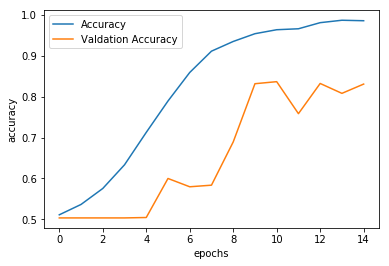

In [7]:
import matplotlib.pyplot as plt

plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

In [8]:
train_loss, train_accuracy = model.evaluate(input_train, y_train, batch_size=batch_size)
train_accuracy

25000/25000 [==============================] - 16s 659us/sample - loss: 0.2308 - accuracy: 0.9284


0.92836

In [9]:
test_loss, test_accuracy = model.evaluate(input_test, y_test, batch_size=batch_size)
test_accuracy

25000/25000 [==============================] - 18s 703us/sample - loss: 0.4162 - accuracy: 0.8174


0.81736

In [20]:
# precition
model.predict(input_test[0:5])

array([[0.26075655],
       [0.97113156],
       [0.8640883 ],
       [0.24265748],
       [0.9815538 ]], dtype=float32)

In [11]:
# ground truth
y_test[0:5]

array([0, 1, 1, 0, 1])